# Demonstrating the optDMD and BOP-DMD using a simple example.

Bagging-Optimized Dynamic Mode Decomposition (BOP-DMD) and Optimized Dynamic Mode Decomposition (optDMD)

Citations:

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

- **Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)**: Sashidhar, D., & Kutz, J. N. (2022). Bagging, optimized dynamic mode decomposition for robust, stable forecasting with spatial and temporal uncertainty quantification. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2229). https://doi.org/10.1098/rsta.2021.0199

## Details

Both the optDMD and BOP-DMD were previously only matlab implementations. The focus of this notebook is the implementation and testing of crude python translations.

1) optDMD: Provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots. 

2) The BOP-DMD takes advantage of this property and solves the DMD using statistical bagging (i.e., randomly selected ensembles) for constructing the DMD.

The advantage of the combined BOP-DMD is: (a) the additional ability to provide uncertainty estimates in the DMD solutions, especially the uncertainty in the spatial modes, (b) the ability to better represent the time dynamics for more complex systems such as those commonly found in geophysics, and (c) robustly solving the DMD for noisy data.

It takes several minutes to run the notebook due to the number of noisy realizations and the size of the ensembles. The demonstration of the bug is run on ammended data set for ease of understanding.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter

### Quick word on warnings:

The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# A REALLY STUPID workaround until I make this a package.
get_directories = True
if get_directories:
    notebook_dir = os.getcwd()
    package_dir = os.path.join(notebook_dir, '../..')
    sys.path.append(package_dir)
    from py_optDMD.src import *
    get_directories = False

## Format plots

In [4]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# "A Simple Example"

The optDMD and the BOP-DMD are both demonstrated using the "Simple Example" from Sashidhar and Kutz (2022). Here data generated from 3 spatial modes are fit. Each mode has time dynamics which are exponential in time.

The specifics of this implementation follow from https://github.com/dsashid/BOP-DMD/blob/main/BOP_DMD_main.m

The results from the python version will be compared to the results from a similar test in matlab.

In [5]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 1
nx = 200

# Space component is evenly spaced originally.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dynamics.
t0 = 0
t1 = 1
nt = 100
ts = np.linspace(t0,t1,nt)[np.newaxis, :]

# Eigenvalues for each mode
e1 = 1 + 0j
e2 = -2 + 0j
e3 = 0 + 1j
true_eigenvalues = np.array([e1, e2, e3])

# Generate the clean, noiseless dynamics.
xclean = f1.dot(np.exp(e1 * ts)) + f2.dot(np.exp(e2 * ts)) + f3.dot(np.exp(e3 * ts))

# BOP-DMD


## Helper function: build xarray containers for ensemble results

This is not strictly necessary, but xarray is a nice data container that enables easier exploration of ensemble results.

In [6]:
def build_ensemble_xarray(data, ds_previous=None, num_eigenvalues=3, column_name='ensemble member', concat_dim='cycle', variable_name='eigenvalue'):
    """Convert the results to an xarray Dataset.
    
    Dataset has coordinates of index (a melt of eigenvalue and ensemble member) 
    and cycle (number of ensembles created). The cycle dimension is the dimension
    along which ensembles are stacked in the concatenation.
    """
    
    # Build the eigenvalues dimension
    eigenvalues_coord = [str(k) for k in np.arange(1, num_eigenvalues + 1)]
    
    # Convert to a Pandas dataframe to use the melt function.
    # Build the real component
    df_real = pd.DataFrame(
        data=data.real,
    )

    df_real[variable_name] = eigenvalues_coord
    df_real.columns.names = [column_name]

    df_real = pd.melt(df_real, id_vars=variable_name, value_name='real')

    mi = pd.MultiIndex.from_frame(df_real[[column_name, variable_name]])
    df_real.index = mi
    df_real = df_real.drop([column_name, variable_name], axis=1)

    # Build the imaginary component.
    df_imag = pd.DataFrame(
        data=data.imag,
    )

    df_imag[variable_name] = eigenvalues_coord
    df_imag.columns.names = [column_name]

    df_imag = pd.melt(df_imag, id_vars=variable_name, value_name='imag')

    mi = pd.MultiIndex.from_frame(df_imag[[column_name, variable_name]])
    df_imag.index = mi
    df_imag = df_imag.drop([column_name, variable_name], axis=1)

    # Concatenate the real and imaginary components into a single Dataframe.
    df = pd.concat(
        [df_real, df_imag], axis=1
    )

    # Drop the duplicate columns from the melt.
    # df = df.loc[:,~df.columns.duplicated()]

    # Convert to xarray since this better handles the multidimensional data.
    ds = xr.Dataset.from_dataframe(df)
    if ds_previous is None:
        ds = ds
    else:
        ds = xr.concat([ds_previous, ds], dim='cycle')
        
    return ds

## Helper function: pretty evaluation plots

A helper plotting function to simplify making the same plot for each test.

In [7]:
def eigenvalue_scatterplot(ds, true_eigenvalues, lims=(-3, 3)):
    """Distribution of eigenvalues using a seaborn jointplot.
    
    """

    g = sns.jointplot(
        data=ds.to_dataframe(),
        x="real",
        y="imag",
        hue='eigenvalue',
        marginal_kws={'clip': lims}
    )

    g.ax_joint.set_xlim(lims)
    g.ax_joint.set_ylim(lims)
    g.ax_joint.scatter(
        np.real(true_eigenvalues),
        np.imag(true_eigenvalues),
        30,
        color='k',
        marker='o',
        label='True Eigenvalues'
    )
    g.ax_joint.legend()
    g.fig.tight_layout()
    
    return g

## Debug very large values of sigma

When sigma becomes "large" ($\sigma > 0.05$) the BOP-DMD algorithm tends to produce some nonsensically terrible eigenvalue solutions. Here, these are directly investigated by forcing the algorithm to re-run in verbose mode.

The result appears to show the algorithm failing when it never exists the predicted lambda solutions strategy before reaching the maximum number of iterations.

The algorithm is only run on an abbreviated dataset for ease of digesting. In larger runs, this problem can impact an entire ensemble, leading to very erroneous results.

In [8]:
# Set the random seed
rng = np.random.default_rng(1)

# Number of time points
n = len(ts)

# Number you want to choose (for each ensemble member?)
p = 50
# Number of noise cycles
num_noise_cycles = 5
# number of cycles for each noise cycle
num_cycles =  25

sigma_array = [1e-1]

for sigma in sigma_array:
    print('')
    print('======================')
    print('sigma={}\n'.format(sigma))

    # Create containers for the eigenvalues
    e_optDMD = np.zeros((3, num_noise_cycles)).astype(complex)
    e_mean_BOPDMD = np.zeros((3, num_noise_cycles)).astype(complex)
    e_std_BOPDMD = np.zeros((3, num_noise_cycles))

    # Substantiate the dataset variables.
    ds_optdmd = None
    # Dataset for the entire ensemble
    ds_entire_ensemble_bopdmd = None
    
    for k in range(num_noise_cycles):
        print(
            'Working on ensemble {} out of {} total ensembles.'.format(
                k + 1,
                num_noise_cycles
            ),
            # end='\r'
        )
        # Create data for noise cycle (add random noise)
        xdata = xclean + sigma * rng.standard_normal(xclean.shape)

        # Create the lambda vector for ensembleDMD cycle
        e_ensembleDMD = np.zeros((3, num_cycles)).astype(complex)

        # Try the DMD -- putting this off until I can figure out how the pydmd and this unknown
        # DMD function relate to each other. Should be straightforward.
        # phi_DMD, lam_DMD, b_DMD, sig_DMD = DMD(xdata(:,1:end-1), xdata(:,2:end), 3);

        # Try the regular optdmd (without bagging)
        w_opt, e_opt, b_opt, _ = optimalDMD.optdmd(xdata, ts, 3, 1)

        # Match the eigenvalues to the true ones using the Munkres algorithm.
        _, indices = bop_dmd.match_vectors(e_opt, true_eigenvalues)
        e_optDMD[:, k] = e_opt[indices]
        
        for j in range(num_cycles):
            # Randomly select time indices for this ensemble member.
            ind = rng.integers(low=0, high=ts.size - 1, size=p)

            # Sort the index to be in ascending order, generating variable length time steps.
            ind = np.sort(ind)

            # Create the subselected data using the sorted indices.
            xdata_cycle = xdata[:, ind]
            ts_ind = ts[:, ind]

            # For very high levels of noise the linear least squares svd solver
            # can fail. Catch those and pass on to the next ensemble member.
            print(j)
            try:
                # Solve optdmd for this ensemble member. Use optDMD modes as initial
                # conditions for BOP-DMD
                w_cycle, e1_cycle, b_cycle, exit_mode = optimalDMD.optdmd(
                    xdata_cycle,ts_ind, 3, 0, alpha_init=e_opt, verbose=False
                )
                
                # Match the eigenvalues to the true ones using the Munkres algorithm.
                _, indices = bop_dmd.match_vectors(e1_cycle, true_eigenvalues)
                
                # Evaluate the eigenvalues against the actual eigenvalues for debugging.
                relerr_e = (
                    np.linalg.norm(e1_cycle[indices] - true_eigenvalues, 2)
                    / np.linalg.norm(true_eigenvalues, 2)
                )
                
                if relerr_e > 0.5:
                    print('Bad eigenvalue solution, becoming verbose')
                    
                    w_cycle, e1_cycle, b_cycle, exit_mode = optimalDMD.optdmd(
                        xdata_cycle,ts_ind, 3, 0, alpha_init=e_opt, verbose=True
                    )
                    # Match the eigenvalues to the true ones using the Munkres algorithm.
                    _, indices = bop_dmd.match_vectors(e1_cycle, true_eigenvalues)

                    # Evaluate the eigenvalues against the actual eigenvalues for debugging.
                    relerr_e = (
                        np.linalg.norm(e1_cycle[indices] - true_eigenvalues, 2)
                        / np.linalg.norm(true_eigenvalues, 2)
                    )
                    
                    print('Relative error in eigenvalues {:.4f}'.format(relerr_e))

                    x1 = np.dot(np.dot(w_cycle, np.diag(b_cycle)), np.exp(np.dot(e1_cycle[:, np.newaxis], ts_ind)))
                    relerr_r = np.linalg.norm(x1 - xdata_cycle) / np.linalg.norm(xdata_cycle)
                    print('Relative error in reconstruction {:.4f}'.format(relerr_r))
                
                # Assign to the outer container using the correct ordering.
                e_ensembleDMD[:, j] = e1_cycle[indices]

            except np.linalg.LinAlgError:
                print('Failed')
                e_ensembleDMD[:, j] = np.complex(np.nan)
            print()
                
        print('=============================')
        e_mean_BOPDMD[:, k] = np.mean(e_ensembleDMD, 1)
        relerr_e = (
            np.linalg.norm(e_mean_BOPDMD[:, k] - true_eigenvalues, 2)
            / np.linalg.norm(true_eigenvalues, 2)
        )
        print('Mean Eigenvalues Error {:.4f}'.format(relerr_e))
        e_std_BOPDMD[:, k] = np.std(e_ensembleDMD, 1)
        print('std Eigenvalues:')
        print(e_std_BOPDMD[:, k])
        
        print('=============================')
        
        # Convert the results to an xarray Dataset. Dataset has coordinates of
        # index (a melt of eigenvalue and ensemble member) and cycle (number of
        # ensembles created).
        ds_entire_ensemble_bopdmd = build_ensemble_xarray(e_ensembleDMD, ds_previous=ds_entire_ensemble_bopdmd)

    ds_optdmd = build_ensemble_xarray(e_optDMD, ds_previous=ds_optdmd, )
    ds_mean_bopdmd = build_ensemble_xarray(e_mean_BOPDMD, ds_previous=None, variable_name='eigenvalue')
    
    ds_std_bopdmd = build_ensemble_xarray(e_std_BOPDMD, ds_previous=None, variable_name='eigenvalue')
    new_names = {dv: dv + '_std' for dv in ds_std_bopdmd.data_vars}
    ds_std_bopdmd = ds_std_bopdmd.rename_vars(new_names)

    ds_bopdmd = xr.merge([ds_mean_bopdmd, ds_std_bopdmd])


sigma=0.1

Working on ensemble 1 out of 5 total ensembles.
0

1

2

3

4

5

6

7

8

9

10

11

12
Bad eigenvalue solution, becoming verbose
Used predicted improvement in lambda
step 0 err 45.81120877548238 lambda 0.3333333333333333
eigenvalues: 
[-2.045-0.127j  1.031-0.51j  -0.118+0.204j]
Used gradient descent in lambda
step 1 err 45.80806622133245 lambda 0.6666666666666666
eigenvalues: 
[-2.18 -0.118j  0.972-0.528j -0.282+0.253j]
Used predicted improvement in lambda
step 2 err 45.78610539718633 lambda 0.2222222222222222
eigenvalues: 
[-2.317-0.038j  0.873-0.463j -0.299+0.195j]
Used predicted improvement in lambda
step 3 err 45.77242202678435 lambda 0.07407407407407407
eigenvalues: 
[-2.422+0.035j  0.627-0.362j -0.623+0.045j]
Used predicted improvement in lambda
step 4 err 45.75614987135176 lambda [0.029]
eigenvalues: 
[-2.556+0.063j  0.562-0.148j -1.201-0.22j ]
Used predicted improvement in lambda
step 5 err 45.72916107444317 lambda [0.01]
eigenvalues: 
[-2.879-0.116j  0.619-0.115j

### Visualize the results: Eigenvalues

#### BOP-DMD

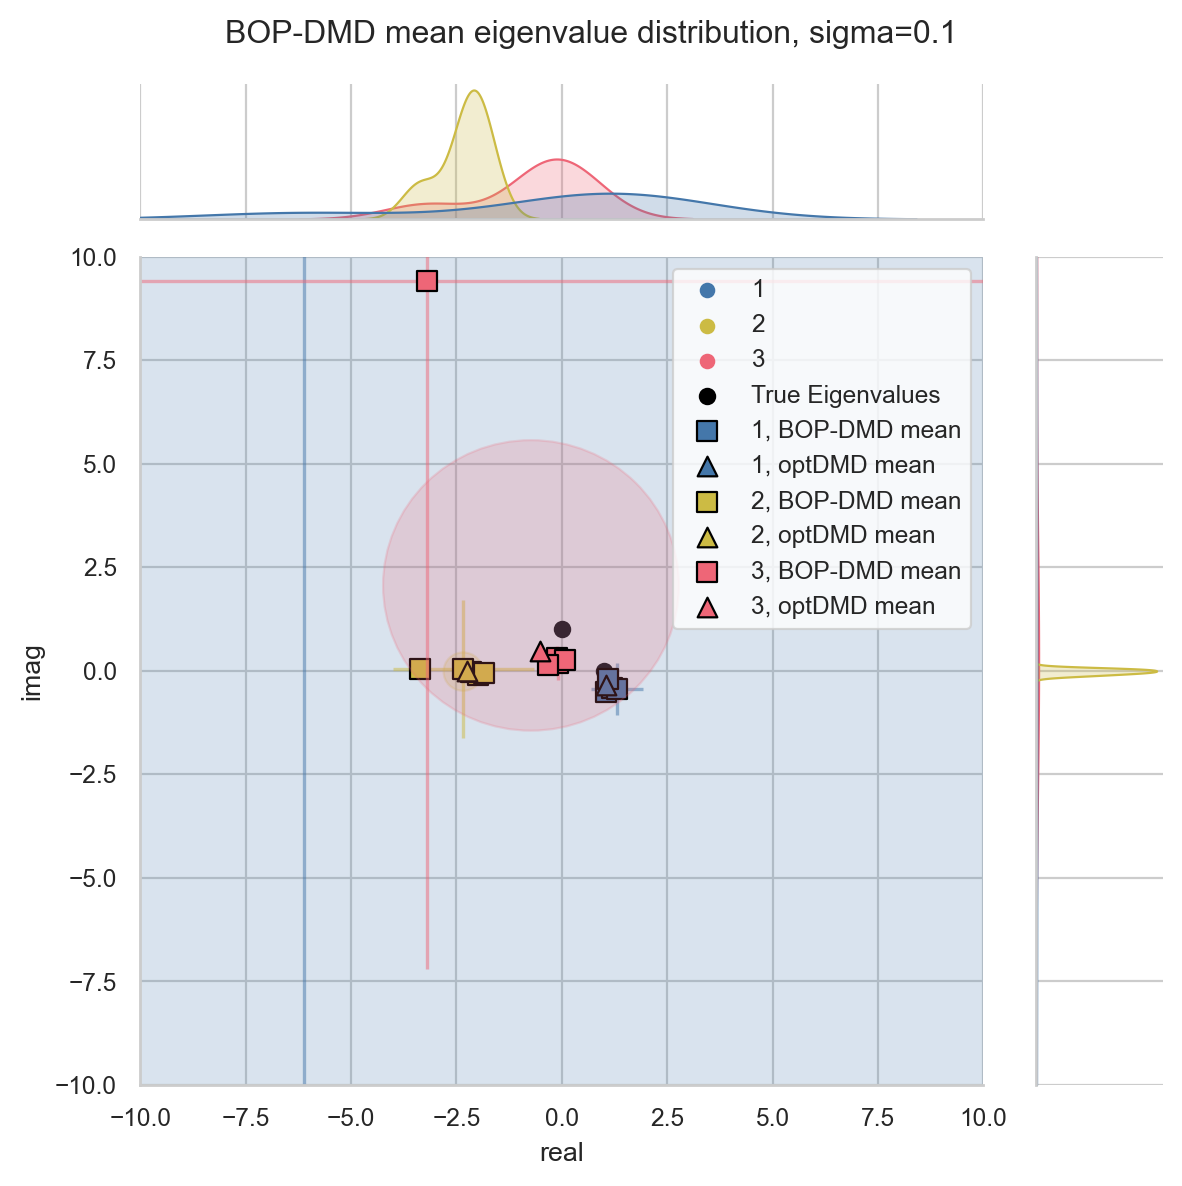

In [9]:
g = eigenvalue_scatterplot(ds_bopdmd, true_eigenvalues, lims=(-10, 10))
g.fig.suptitle("BOP-DMD mean eigenvalue distribution, sigma={}".format(sigma))

for nk, k in enumerate(ds_bopdmd.eigenvalue):
    ds = ds_bopdmd.sel(eigenvalue=k,)
    ds_mean = ds.mean(dim='ensemble member')

    # Errorbars for each noise realization across the entire ensemble
    g.ax_joint.errorbar(
        ds['real'],
        ds['imag'],
        xerr=ds['real_std'],
        yerr=ds['real_std'],
        fmt='none',
        color=tol_bright_reorder[nk],
        zorder=1,
        alpha=0.5,
    )

    # Circle of the total eigenvalue uncertainty across all realizations
    e_std_circle = plt.Circle(
        (ds_mean['real'], ds_mean['imag']),
        ds_mean.real_std.values,
        color=tol_bright_reorder[nk],
        alpha=0.2
    )
    g.ax_joint.add_patch(e_std_circle)
    g.ax_joint.scatter(
        ds['real'],
        ds['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='s',
        edgecolor='k',
        label='{}, BOP-DMD mean'.format(k.values)
    )

    ds = ds_optdmd.sel(eigenvalue=k).mean(dim='ensemble member')
    g.ax_joint.scatter(
        ds['real'],
        ds['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='^',
        edgecolor='k',
        label='{}, optDMD mean'.format(k.values)
    )
    g.ax_joint.legend()
g.fig.savefig('python_BOP-DMD.sigma={}.noise-bug.png'.format(sigma))
g.fig.tight_layout()

Circles are centered on the mean BOP-DMD eigenvalue with a radius equal to the standard deviation across noisy realizations. Error bars are the uncertainty within the ensemble for each realization. The triangles are the mean optDMD eigenvalues across all noisy realizations.

Note the exceptionally large axes scales.

__Observations__

The within ensemble uncertainty is _MUCH_ smaller than the uncertainty between noisy realization. As certain noisy realizations tend to generate eigenvalue solutions very far from the true ones, it suggests that the problem truly lies on the lambda search that relies just on the predicted vs actual improvement.

Some realizations simply generate hopelessly wrong eigenvalues. That's not good!

In case it is easier to look at, here is the same plot without the error bars.

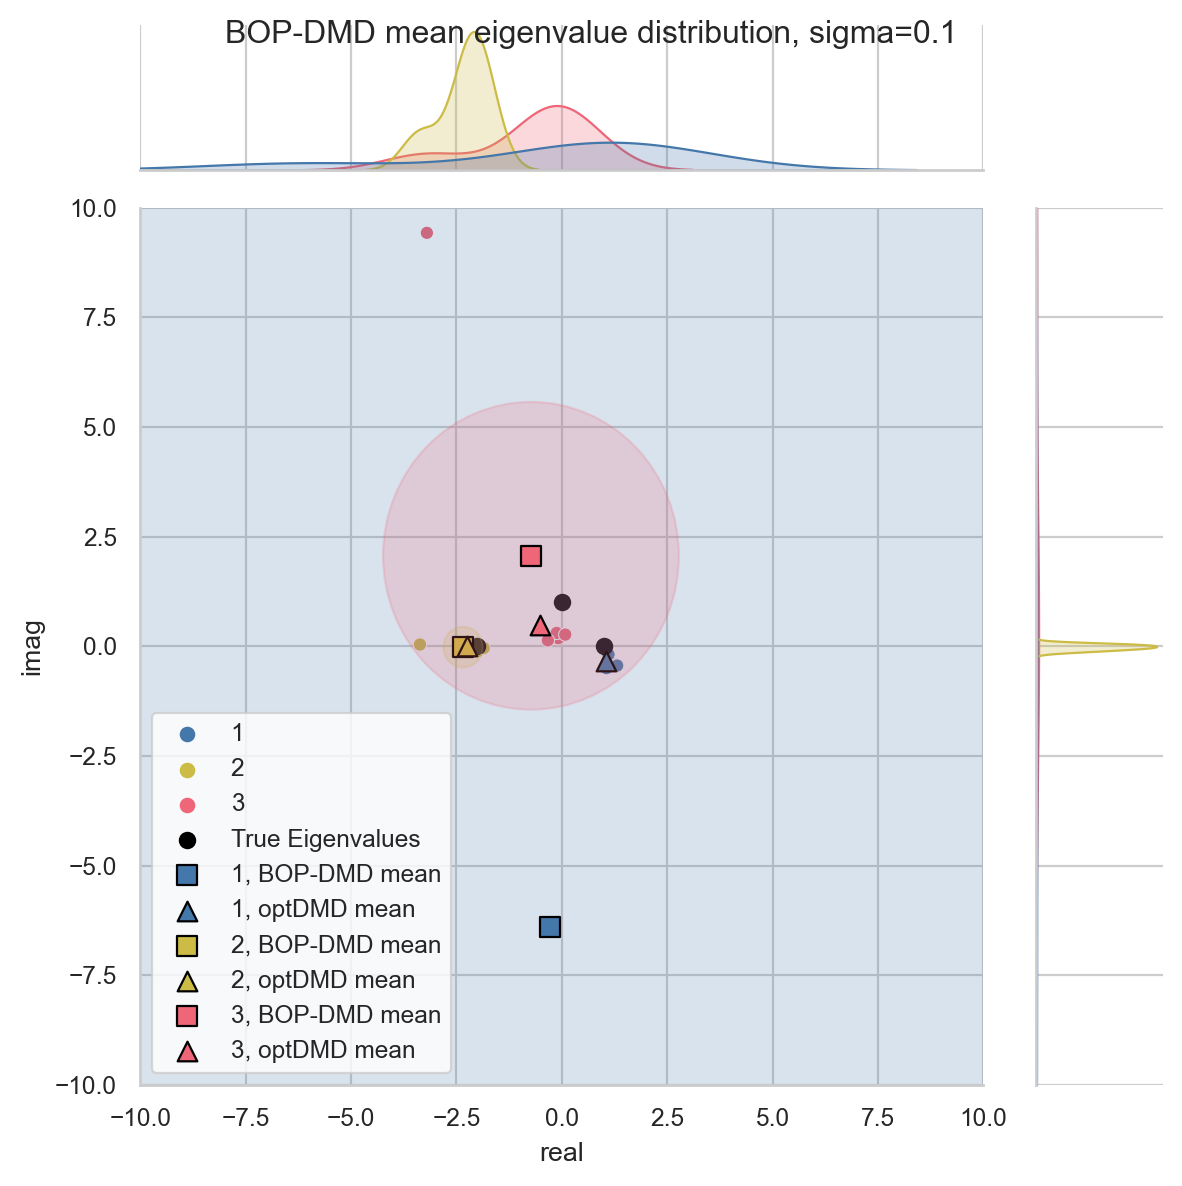

In [10]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
lims = (-10, 10)
g = eigenvalue_scatterplot(ds_bopdmd, true_eigenvalues, lims=(-10, 10))
g.fig.suptitle("BOP-DMD mean eigenvalue distribution, sigma={}".format(sigma))

for nk, k in enumerate(ds_bopdmd.eigenvalue):
    ds = ds_bopdmd.sel(eigenvalue=k).mean(dim='ensemble member')
    e_error = ds.real_std.values

    e_std_circle = plt.Circle((ds['real'], ds['imag']), ds.real_std.values, color=tol_bright_reorder[nk], alpha=0.2)
    g.ax_joint.add_patch(e_std_circle)
    g.ax_joint.scatter(ds['real'], ds['imag'], 50, color=tol_bright_reorder[nk], marker='s', edgecolor='k', label='{}, BOP-DMD mean'.format(k.values))

    ds = ds_optdmd.sel(eigenvalue=k).mean(dim='ensemble member')
    g.ax_joint.scatter(ds['real'], ds['imag'], 50, color=tol_bright_reorder[nk], marker='^', edgecolor='k', label='{}, optDMD mean'.format(k.values))
    g.ax_joint.legend()

# g.fig.savefig('python_BOP-DMD.sigma={}.noise-bug.png'.format(sigma))

#### optDMD for comparison

In comparison, the optDMD doesn't have this problem. From experimentation we know this means that stalling solutions should be acceptable and that it must be the other algorithm branches that are at fault.

Text(0.5, 0.98, 'optDMD eigenvalue distribution, sigma=0.1')

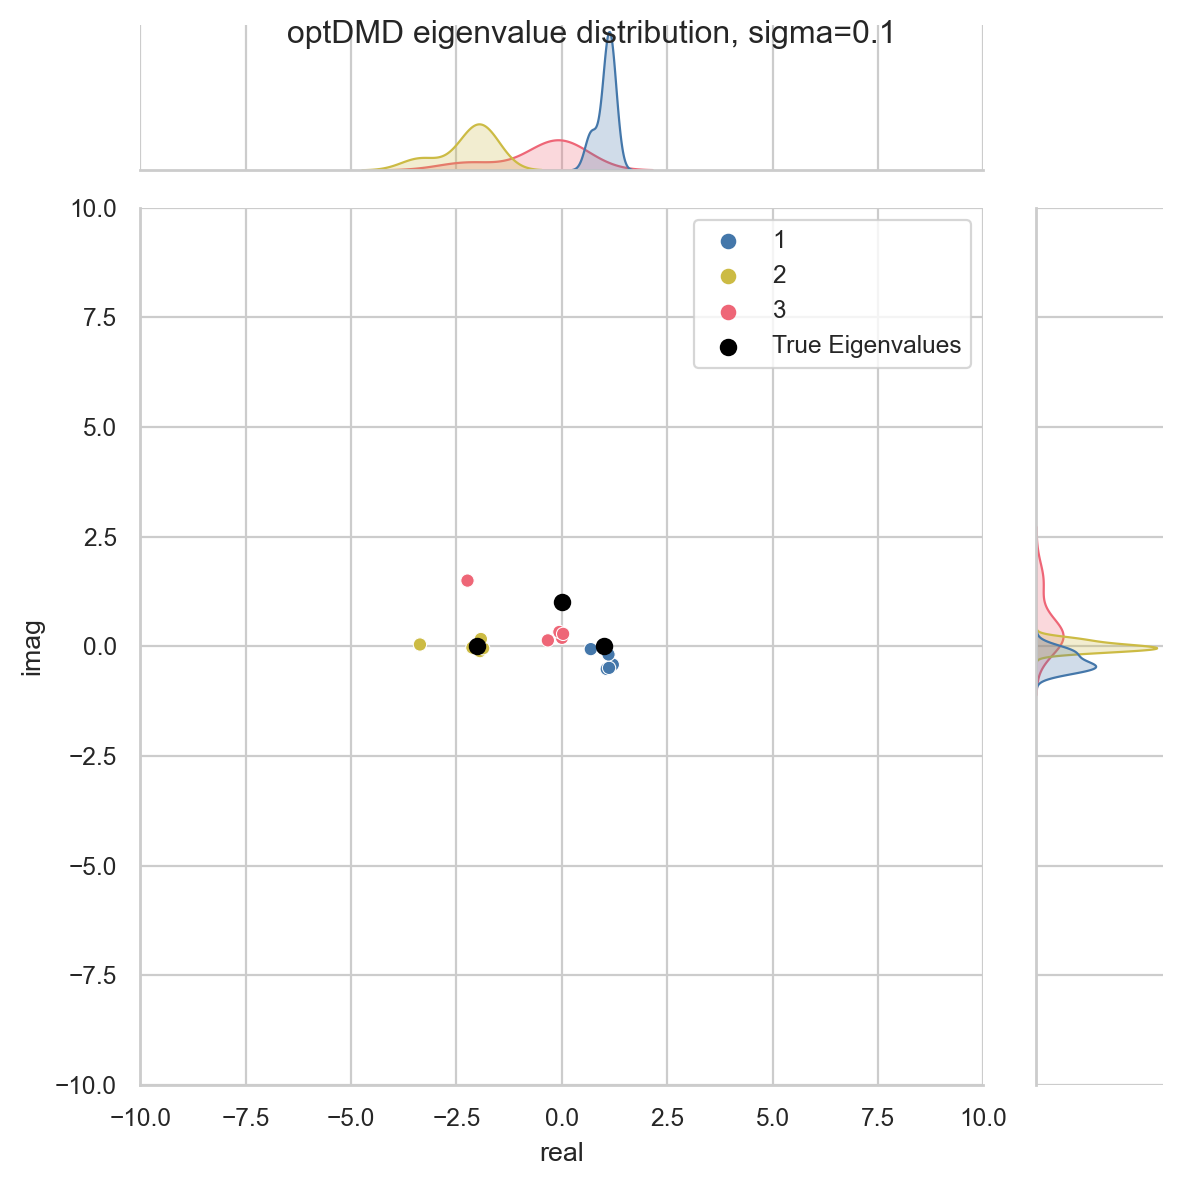

In [11]:
g = eigenvalue_scatterplot(ds_optdmd, true_eigenvalues, lims=(-10, 10))
g.fig.suptitle("optDMD eigenvalue distribution, sigma={}".format(sigma))

## Re-do, removing bad solutions

Discard the ensembler member and re-draw when optDMD exits using with: - maximum number of iterations and - using the predicted lambda search.

In [12]:
# Set the random seed
rng = np.random.default_rng(1)

# Number of time points
n = len(ts)

# Number you want to choose (for each ensemble member?)
p = 50
# Number of noise cycles
num_noise_cycles = 25
# number of cycles for each noise cycle
num_cycles =  100

sigma_array = [1e-1]

for sigma in sigma_array:
    print('')
    print('======================')
    print('sigma={}\n'.format(sigma))

    # Create containers for the eigenvalues
    e_optDMD = np.zeros((3, num_noise_cycles)).astype(complex)
    e_mean_BOPDMD = np.zeros((3, num_noise_cycles)).astype(complex)
    e_std_BOPDMD = np.zeros((3, num_noise_cycles))

    # Substantiate the dataset variables.
    ds_optdmd = None
    # Dataset for the entire ensemble
    ds_entire_ensemble_bopdmd = None
    
    for k in range(num_noise_cycles):
        print(
            'Working on ensemble {} out of {} total ensembles.'.format(
                k + 1,
                num_noise_cycles
            ),
            # end='\r'
        )
        # Create data for noise cycle (add random noise)
        xdata = xclean + sigma * rng.standard_normal(xclean.shape)

        # Create the lambda vector for ensembleDMD cycle
        e_ensembleDMD = np.zeros((3, num_cycles)).astype(complex)

        # Try the DMD -- putting this off until I can figure out how the pydmd and this unknown
        # DMD function relate to each other. Should be straightforward.
        # phi_DMD, lam_DMD, b_DMD, sig_DMD = DMD(xdata(:,1:end-1), xdata(:,2:end), 3);

        # Try the regular optdmd (without bagging)
        w_opt, e_opt, b_opt, _ = optimalDMD.optdmd(xdata, ts, 3, 1)

        # Match the eigenvalues to the true ones using the Munkres algorithm.
        _, indices = bop_dmd.match_vectors(e_opt, true_eigenvalues)
        e_optDMD[:, k] = e_opt[indices]
        
        for j in range(num_cycles):
            # Randomly select time indices for this ensemble member.
            ind = rng.integers(low=0, high=ts.size - 1, size=p)

            # Sort the index to be in ascending order, generating variable length time steps.
            ind = np.sort(ind)

            # Create the subselected data using the sorted indices.
            xdata_cycle = xdata[:, ind]
            ts_ind = ts[:, ind]

            # For very high levels of noise the linear least squares svd solver
            # can fail. Catch those and pass on to the next ensemble member.
            try:
                # Solve optdmd for this ensemble member. Use optDMD modes as initial
                # conditions for BOP-DMD
                w_cycle, e1_cycle, b_cycle, exit_mode = optimalDMD.optdmd(
                    xdata_cycle,ts_ind, 3, 0, alpha_init=e_opt, verbose=False
                )
                
                # Match the eigenvalues to the true ones using the Munkres algorithm.
                _, indices = bop_dmd.match_vectors(e1_cycle, true_eigenvalues)
                
                if exit_mode.lambda_solver == 'predicted' and exit_mode.exit_state == 'maxiter':
                    continue
                    # Assign to the outer container using the correct ordering.
                    e_ensembleDMD[:, j] = np.nan
                else:
                    # Assign to the outer container using the correct ordering.
                    e_ensembleDMD[:, j] = e1_cycle[indices]

            except np.linalg.LinAlgError:
                print('Failed')
                e_ensembleDMD[:, j] = np.complex(np.nan)
                
        print('------------------------------')
        e_mean_BOPDMD[:, k] = np.mean(e_ensembleDMD, 1)
        relerr_e = (
            np.linalg.norm(e_mean_BOPDMD[:, k] - true_eigenvalues, 2)
            / np.linalg.norm(true_eigenvalues, 2)
        )
        print('Mean Eigenvalues Error {:.4f}'.format(relerr_e))
        e_std_BOPDMD[:, k] = np.std(e_ensembleDMD, 1)
        print('std Eigenvalues:')
        print(e_std_BOPDMD[:, k])
        print('------------------------------')
        print()
        
        # Convert the results to an xarray Dataset. Dataset has coordinates of
        # index (a melt of eigenvalue and ensemble member) and cycle (number of
        # ensembles created).
        ds_entire_ensemble_bopdmd = build_ensemble_xarray(e_ensembleDMD, ds_previous=ds_entire_ensemble_bopdmd)

    ds_optdmd = build_ensemble_xarray(e_optDMD, ds_previous=ds_optdmd, )
    ds_mean_bopdmd = build_ensemble_xarray(e_mean_BOPDMD, ds_previous=None, variable_name='eigenvalue')
    
    ds_std_bopdmd = build_ensemble_xarray(e_std_BOPDMD, ds_previous=None, variable_name='eigenvalue')
    new_names = {dv: dv + '_std' for dv in ds_std_bopdmd.data_vars}
    ds_std_bopdmd = ds_std_bopdmd.rename_vars(new_names)

    ds_bopdmd = xr.merge([ds_mean_bopdmd, ds_std_bopdmd])


sigma=0.1

Working on ensemble 1 out of 25 total ensembles.
------------------------------
Mean Eigenvalues Error 0.3961
std Eigenvalues:
[0.355 0.196 0.325]
------------------------------

Working on ensemble 2 out of 25 total ensembles.
------------------------------
Mean Eigenvalues Error 0.6295
std Eigenvalues:
[0.202 0.534 0.228]
------------------------------

Working on ensemble 3 out of 25 total ensembles.
------------------------------
Mean Eigenvalues Error 0.2443
std Eigenvalues:
[0.299 0.396 0.383]
------------------------------

Working on ensemble 4 out of 25 total ensembles.
------------------------------
Mean Eigenvalues Error 0.3876
std Eigenvalues:
[0.445 0.481 0.225]
------------------------------

Working on ensemble 5 out of 25 total ensembles.
------------------------------
Mean Eigenvalues Error 0.8188
std Eigenvalues:
[7.845 0.944 1.167]
------------------------------

Working on ensemble 6 out of 25 total ensembles.
------------------------------
Mean Eigenval

### Visualize the results: Eigenvalues

#### BOP-DMD

This figure is not saved as it is produced in the `ex-BOP-DMD.ipynb` notebook.

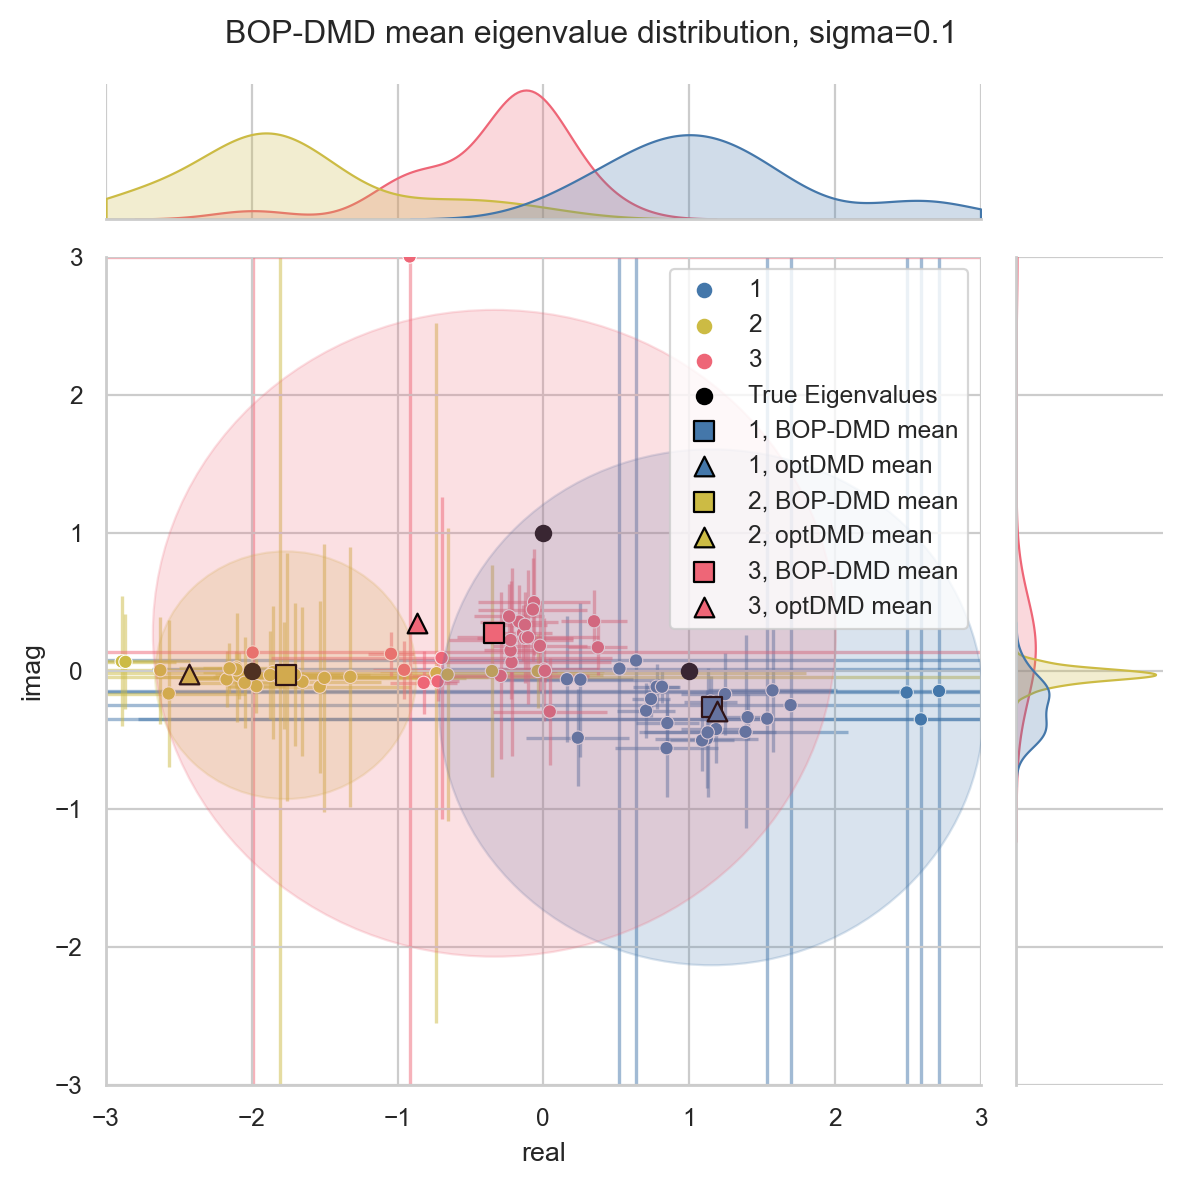

In [16]:
g = eigenvalue_scatterplot(ds_bopdmd, true_eigenvalues, lims=(-3, 3))
g.fig.suptitle("BOP-DMD mean eigenvalue distribution, sigma={}".format(sigma))

for nk, k in enumerate(ds_bopdmd.eigenvalue):
    ds = ds_bopdmd.sel(eigenvalue=k,)
    ds_mean = ds.mean(dim='ensemble member')

    # Errorbars for each noise realization across the entire ensemble
    g.ax_joint.errorbar(
        ds['real'],
        ds['imag'],
        xerr=ds['real_std'],
        yerr=ds['real_std'],
        fmt='none',
        color=tol_bright_reorder[nk],
        zorder=0,
        alpha=0.5,
    )

    # Circle of the total eigenvalue uncertainty across all realizations
    e_std_circle = plt.Circle(
        (ds_mean['real'], ds_mean['imag']),
        ds_mean.real_std.values,
        color=tol_bright_reorder[nk],
        alpha=0.2
    )
    g.ax_joint.add_patch(e_std_circle)
    g.ax_joint.scatter(
        ds_mean['real'],
        ds_mean['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='s',
        edgecolor='k',
        label='{}, BOP-DMD mean'.format(k.values)
    )

    ds = ds_optdmd.sel(eigenvalue=k).mean(dim='ensemble member')
    g.ax_joint.scatter(
        ds['real'],
        ds['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='^',
        edgecolor='k',
        label='{}, optDMD mean'.format(k.values)
    )
    g.ax_joint.legend()
g.fig.tight_layout()

Just in case the error bars are distracting, here is a 2nd version without them.

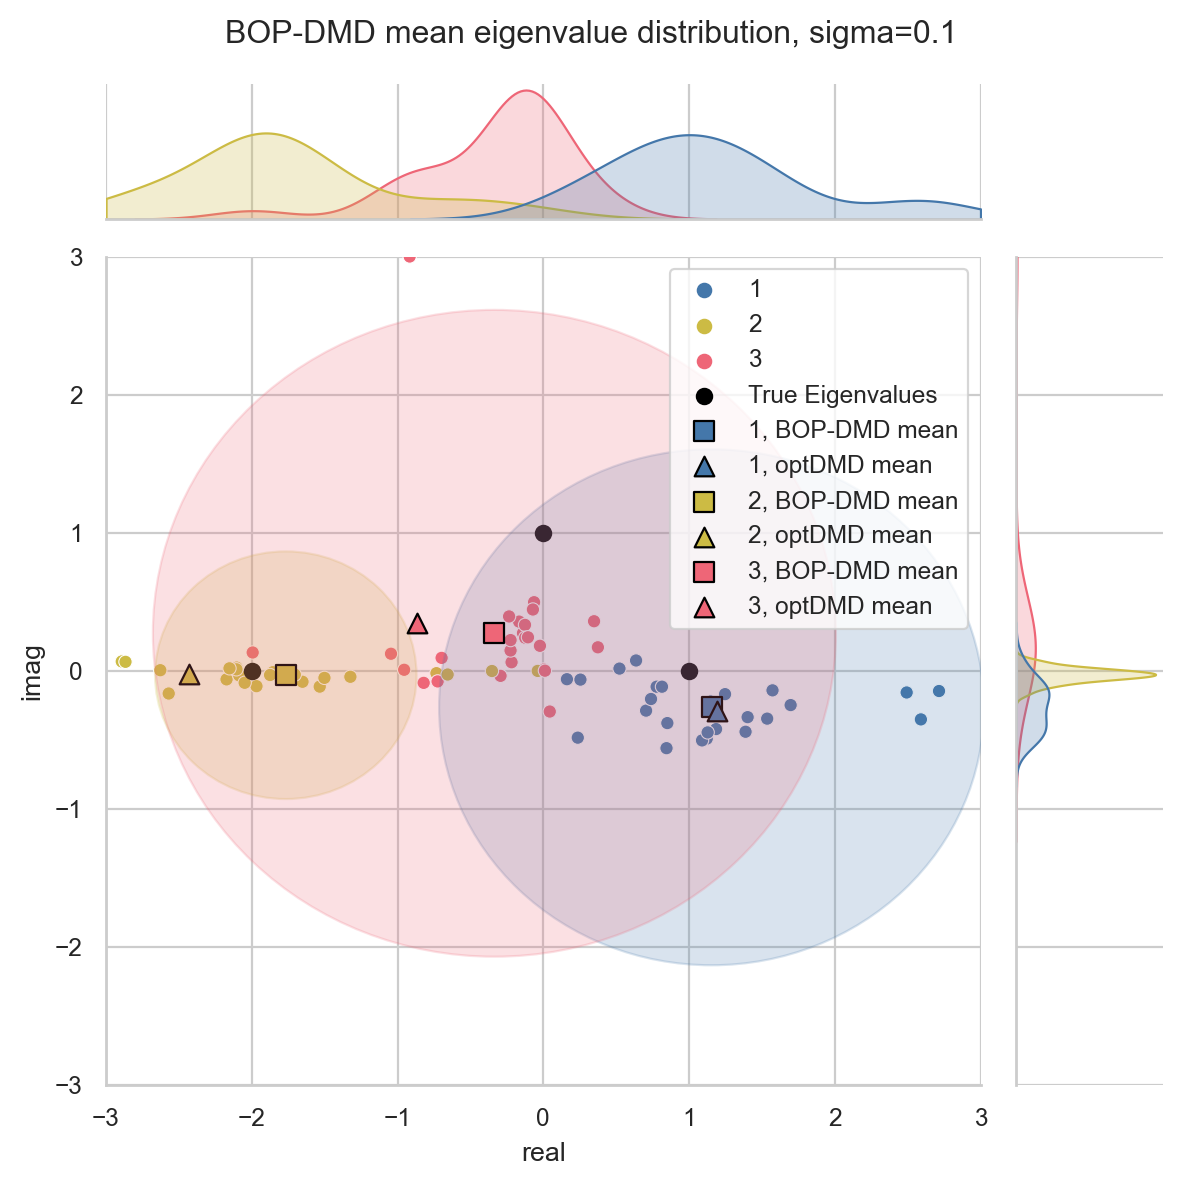

In [14]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
g = eigenvalue_scatterplot(ds_bopdmd, true_eigenvalues, lims=(-3, 3))
g.fig.suptitle("BOP-DMD mean eigenvalue distribution, sigma={}".format(sigma))

for nk, k in enumerate(ds_bopdmd.eigenvalue):
    ds = ds_bopdmd.sel(eigenvalue=k).mean(dim='ensemble member')

    e_std_circle = plt.Circle(
        (ds['real'], ds['imag']),
        ds.real_std.values,
        color=tol_bright_reorder[nk],
        alpha=0.2
    )
    g.ax_joint.add_patch(e_std_circle)
    g.ax_joint.scatter(
        ds['real'],
        ds['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='s',
        edgecolor='k',
        label='{}, BOP-DMD mean'.format(k.values)
    )

    ds = ds_optdmd.sel(eigenvalue=k).mean(dim='ensemble member')
    g.ax_joint.scatter(
        ds['real'],
        ds['imag'],
        50,
        color=tol_bright_reorder[nk],
        marker='^',
        edgecolor='k',
        label='{}, optDMD mean'.format(k.values)
    )
    g.ax_joint.legend()
    
g.fig.tight_layout()

**Note** The change in the axes scales.

#### optDMD for comparison

Text(0.5, 0.98, 'optDMD eigenvalue distribution, sigma=0.1')

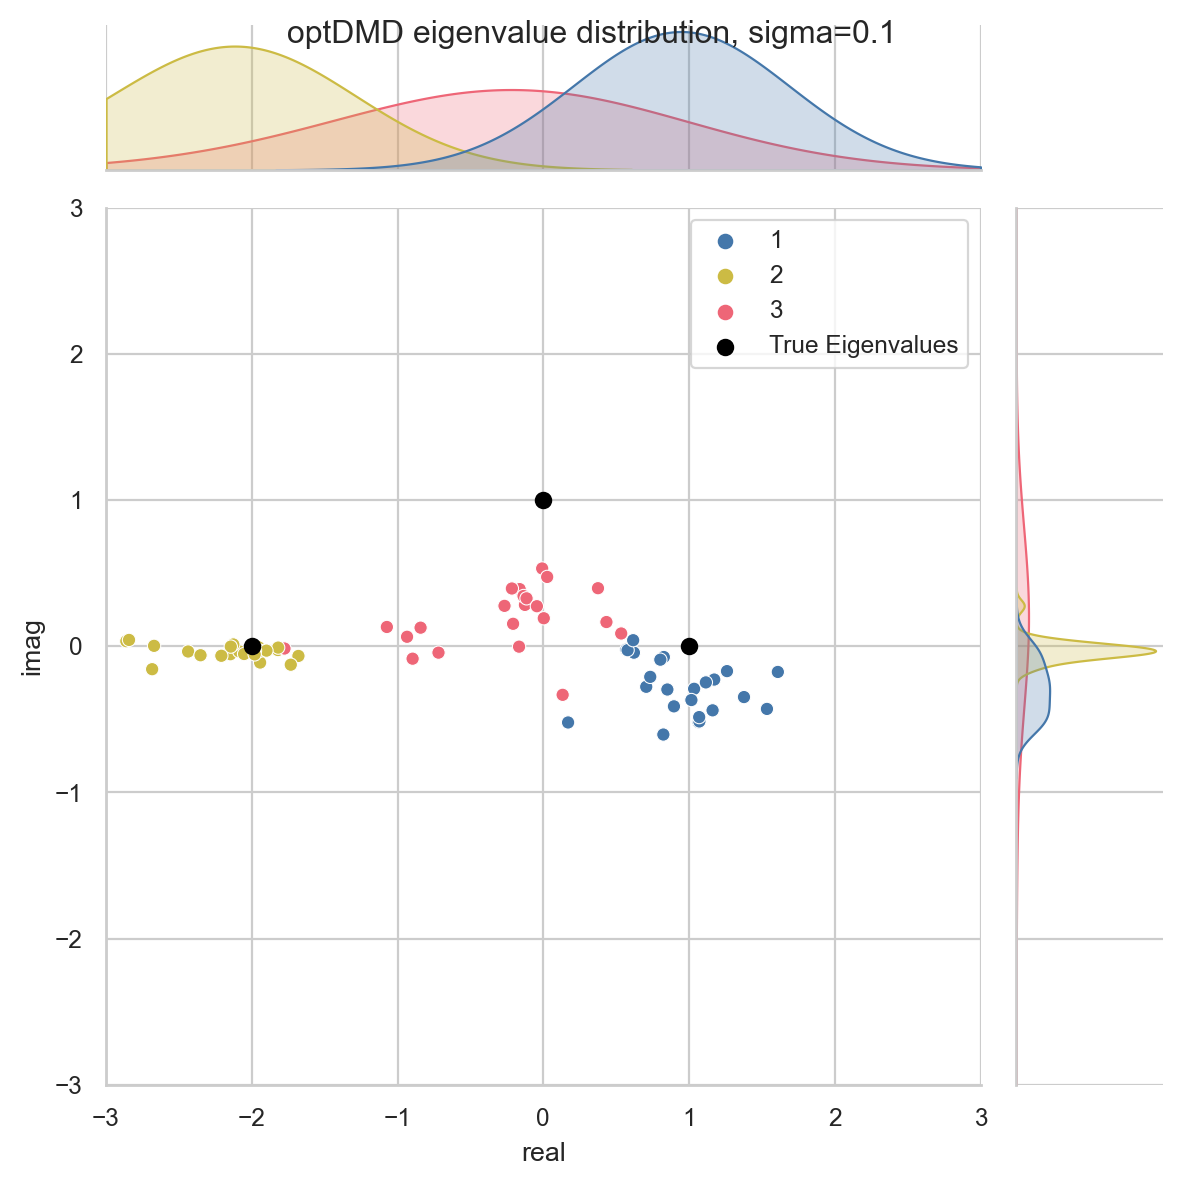

In [15]:
g = eigenvalue_scatterplot(ds_optdmd, true_eigenvalues)
g.fig.suptitle("optDMD eigenvalue distribution, sigma={}".format(sigma))